## CONCEIVE AN APPLICATION FOR THE PUBLIC HEALTH AGENCY: CLEANING PHASE

<div style="width:100%;text-align: center;"> <img align=middle src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/75/Open_Food_Facts_logo.svg/langfr-225px-Open_Food_Facts_logo.svg.png" alt="Heat beating" style="height:200px;margin-top:3rem;"> </div>

Open Food Facts is a free, online and crowdsourced database of food products from around the world.

The project was launched on 19 May 2012 by French programmer Stéphane Gigandet during the Food Revolution Day organized by Jamie Oliver and has won the 2013 Dataconnexions Award from Etalab and the 2015 OKFN Award from Open Knowledge.<br>

In May 2016, its database contained more than 80,000 products from 141 countries. In June 2017, thanks to the growing ecosystem of apps and open data imports from various countries, this number rose to 880,000. In October 2019 OFF passed the 1,000,000 products milestone. In July 2021, the number of products has increased to more than 1,850,000.<br> 

Nutri-Score has already been adopted by several countries, including Germany, France, Belgium, Luxembourg and the Netherlands. However the label is not compulsary and lots of food companies are still reluctant to adopt it which means a large number of products do not have this indication yet.
In addition to that, Italy, the Czech Republic and several other countries have voiced their concerns about the negative impact Nutri-Score may have on their traditional food products.

## Objective

The idea behind this work is to use this huge database in order to conceive an app that would recalculate automatically, from linear regression on different selected parameters, the Nutriscore and Nutrigrade of products that are not input in the database yet or products that do not have the front-of-pack labelling. Customers would also benefit from this app when they travel in countries where the logo has not yet been adopted.<br>

This project will be built on 2 phases:<br>

__1) Cleaning phase:__ This dataset is huge, containing many missing data and information that is not relevant to our app. We need to select what is important for our app and reduce this dataset in order to be able to properly work with it.<br>

__2) Exploration phase:__ We go deep into our remaining parameters to find correlations between Nutriscore and nutrients. We estimate a relationship between them through different regressions. 

## 1) CLEANING PHASE

In [1]:
#! usr/bin/env python 3
# coding: utf-8

# Importing librairies

import numpy as np                # linear algebra
import pandas as pd               # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp                # numerical integration, interpolation, optimization, linear algebra, and statistics
import seaborn as sns             # statistical data visualization
import matplotlib.pyplot as plt   # static, animated, and interactive visualizations in Python

# Due to memory problems and laptop RAM capacity, we started the project through Kaggle before exporting it to Jupyter Notebook.

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/openfactsfood/en.openfoodfacts.org.products.csv


### OVERVIEW OF THE DATASET

Dataset can be found here: https://static.openfoodfacts.org/data/en.openfoodfacts.org.products.csv

In [2]:
df_data = pd.read_csv('../input/openfactsfood/en.openfoodfacts.org.products.csv', sep='\t', low_memory=False, encoding='utf-8')
df_data.head(5)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,abbreviated_product_name,generic_name,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,00000000000000225,http://world-en.openfoodfacts.org/product/0000...,nutrinet-sante,1623855208,2021-06-16T14:53:28Z,1623855209,2021-06-16T14:53:29Z,jeunes pousses,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1561463718,2019-06-25T11:55:18Z,Vitória crackers,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0000000000031,http://world-en.openfoodfacts.org/product/0000...,isagoofy,1539464774,2018-10-13T21:06:14Z,1539464817,2018-10-13T21:06:57Z,Cacao,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,000000000003327986,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1574175736,2019-11-19T15:02:16Z,1624390765,2021-06-22T19:39:25Z,Filetes de pollo empanado,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,000000000004622327,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1619501895,2021-04-27T05:38:15Z,1619501897,2021-04-27T05:38:17Z,Hamburguesas de ternera 100%,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### FEW FONCTIONS DEFINED TO HELP DESCRIBING THE CHARACTERISTICS OF THE INPUT FILES

In [3]:
def duplicates (data):
    """Calculate the number of duplicates in dataframe data"""
    
    return len(data)-len(data.drop_duplicates())


def missing_cells (data):
    """Calculate the number of empty cells in dataframe data"""
    
    return data.isna().sum().sum()


def missing_cells_percent (data):
    """Calculate the percentage of empty cells in dataframe data""" 
    
    return missing_cells(data)/(data.size)*100
    

def filled_cells (data):
    """Calculate the number of existing values in dataframe data"""
    
    return data.notna().sum()  
    

def filled_cells_percent (data):
    """Calculate the percentage of existing values in dataframe data"""
    
    return filled_cells(data)/(len(data.index))*100


In [4]:
from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        #output += df.style.set_table_attributes.[{'selector': 'caption','props': 'caption-side: bottom; font-size:1.25em;'}]
        output += df.style.set_table_attributes("style='display:inline', font-weight: bold").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

### CREATION OF A DATAFRAME SUMMARIZING KEY INFO FROM THE INPUT FILES

In [5]:
# Characteristics of the input file

file_spec = [['Total rows', len(df_data)], ['Total columns', len(df_data.columns)], ['Total duplicates', duplicates(df_data)],
       ['Total Missing cells', missing_cells(df_data)], ['Missing cells (%)', missing_cells_percent(df_data)]]

# Creates Dataframe df_files_spec

df_file_spec = pd.DataFrame(file_spec, columns = ['Characteristics', 'File'])
df_file_spec['File'] = df_file_spec['File'].apply(lambda x: '{:.0f}'.format(x))
df_file_spec.set_index('Characteristics', inplace=True)
df_file_spec

,File
Characteristics,
Total rows,1851742
Total columns,186
Total duplicates,1
Total Missing cells,274420669
Missing cells (%),80


### FIILING RATE OF THE DIFFERENT CATEGORIES IN OUR INPUT FILE

In [6]:
# Remove the only duplicate in dataset
#df_data = df_data.drop_duplicates()

# Exploration of the existing data in each of the 186 column

percent_existing = df_data.notnull().sum() * 100 / len(df_data)
existing_data_df = pd.DataFrame({'Column label': df_data.columns,
                                 'Existing data pct': percent_existing})
existing_data_df.reset_index(drop=True, inplace=True)
existing_data_df.sort_values('Existing data pct', ascending=False, inplace=True)
#pd.options.display.max_rows = 200
existing_data_df.index = np.arange(1, len(existing_data_df)+1)
existing_data_df['Existing data pct'] = existing_data_df['Existing data pct'].astype(float, errors = 'raise')
round(existing_data_df, 2)

,Column label,Existing data pct
1,code,100.0
2,last_modified_datetime,100.0
3,states,100.0
4,states_tags,100.0
5,states_en,100.0
...,...,...
182,ingredients_from_palm_oil,0.0
183,no_nutriments,0.0
184,allergens_en,0.0
185,cities,0.0


### DATA CLEANING: 1st PHASE - THRESHOLD ON FILLING RATE IMPOSED ON OUR DATASET

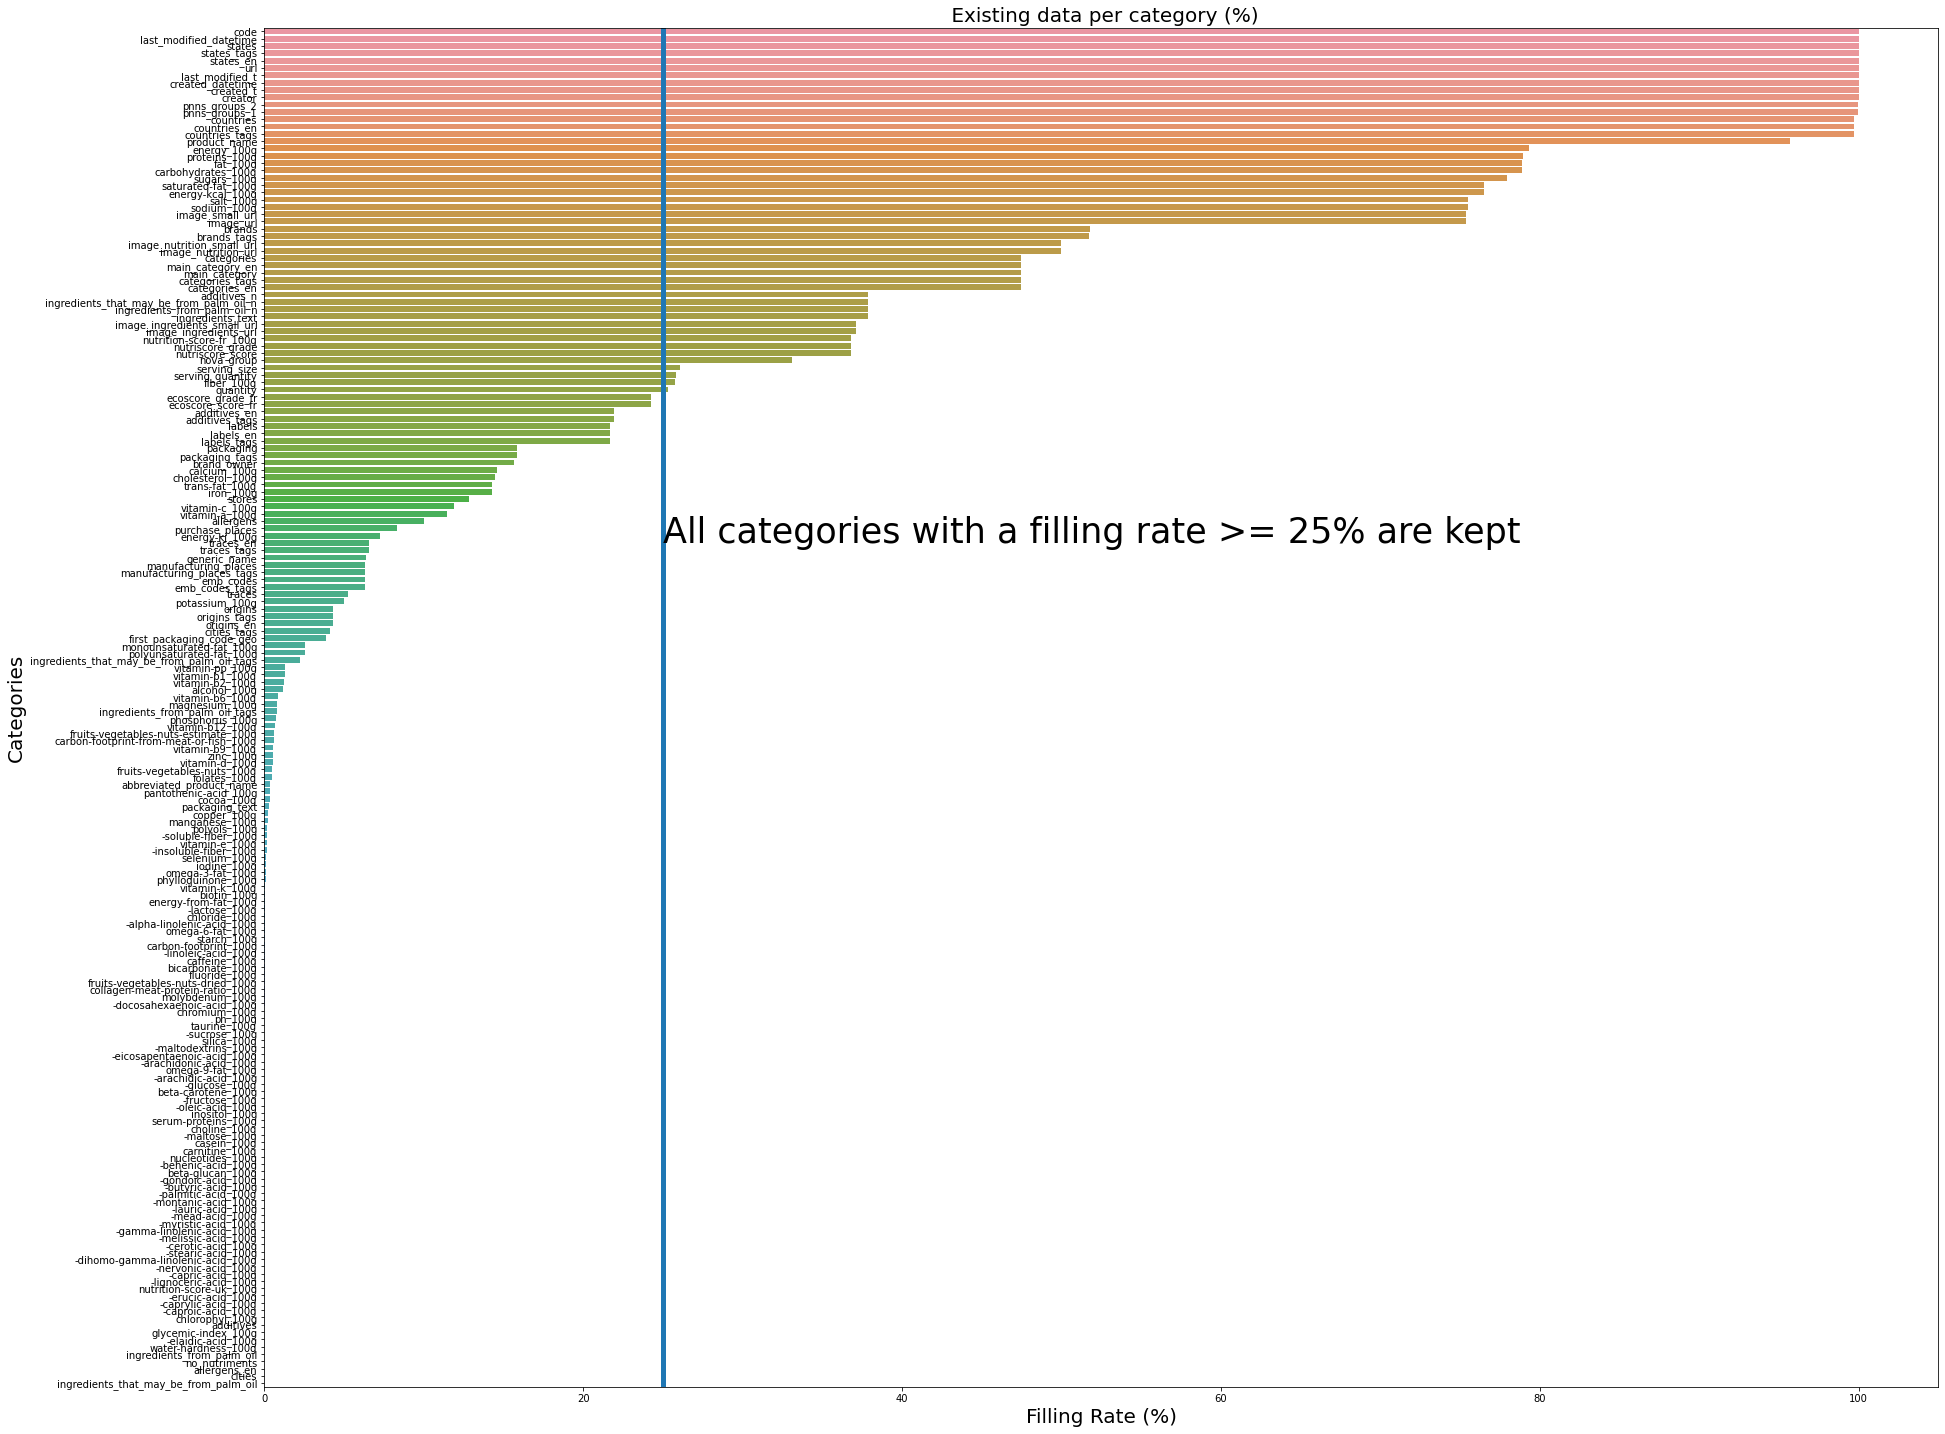

In [7]:
# Threshold input
limitPer = 25
fig = plt.figure(figsize=(30, 25))
font_title = {'weight': 'bold', 'size': 30} 

sns.barplot(x="Existing data pct", y="Column label", data=existing_data_df) 
plt.axvline(x=limitPer, linewidth=5)
plt.text(limitPer, 70, 'All categories with a filling rate >= 25% are kept ', fontsize = 35) 
plt.title(" Existing data per category (%)", fontsize = 20) 
plt.xlabel("Filling Rate (%)", fontsize = 20)
plt.ylabel("Categories", fontsize = 20)

# We decided to set up a 25% filling rate threshold to reduce categories with too much missing data
# Threshold was mainly decided with regards to the category Fibers which can potentially be an important factor in the Nutriscore calculation
limitPer = 0.24
Filter = len(df_data) * limitPer
df_data1 = df_data.dropna(thresh=Filter, axis=1)

plt.show()

In [8]:
df_data1.shape

(1851742, 52)

#### OVERVIEW OF INPUT ITEMS PER COUNTRY

In [9]:
# List of all the countries that have products data
# Some creators input strings of countries that we need to split into individual countries

# Before split
pays_counts1 = df_data1['countries_en'].value_counts(dropna=True, sort=True)
df_pays_counts1 = pd.DataFrame(pays_counts1)
df_pays_counts1.index.name = 'Countries'
df_pays_counts1.columns = ['Number of records']
df_pays_counts_rec1 = df_pays_counts1.head(5).append(df_pays_counts1.tail(5))

# Split, stack & join
df_country = df_data1.drop('countries_en', axis=1).join(df_data1['countries_en'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).rename('Countries'))
df_countries = df_country.drop_duplicates()

# After split
pays_counts2 = df_countries['Countries'].value_counts(dropna=True, sort=True)
df_pays_counts2 = pd.DataFrame(pays_counts2)
df_pays_counts2.index.name = 'Countries'
df_pays_counts2.columns = ['Number of records']
df_pays_counts_rec2 = df_pays_counts2.head(5).append(df_pays_counts2.tail(5))

display_side_by_side([df_pays_counts_rec1, df_pays_counts_rec2], ['Before split', 'After split'])

,Number of records
Countries,
France,744394
United States,352186
Spain,207009
Italy,87415
Germany,67280
"Belgium,Germany,Poland",1
"Italy,Netherlands,Portugal",1
"France,French Guiana,Germany,Switzerland",1
"Austria,Denmark,Finland,Germany,Norway,Sweden,Switzerland",1


### DATA CLEANING: 2nd PHASE - FOCUS ON FRANCE DATA

For this study, we decided to keep products available in France only. Open Food Facts is originally a french concept which explains the highest input number of products. There are twice as much referenced products in France than in the US. For USDA data, the ingredients lists aren't full so many products lack additives or allergens, the data has no timestamp, so what you find today in the shelves in the US can be very different from what you see online.

In [10]:
df_france = df_countries[df_countries['Countries'].str.contains('France', na=False)] 
df_france = df_france.drop(['countries', 'countries_tags'], axis=1)
df_france.shape

(816838, 50)

### DATA CLEANING: 3rd PHASE - FOCUS ON ENTRIES WITH NUTRISCORE AVAILABLE

As our app is based on the Nutriscore, all products with no Nutriscore values are removed.

In [11]:
df_nutrifrance = df_france.dropna(axis=0, subset=['nutriscore_score', 'nutriscore_grade'])
df_nutrifrance.shape

(290711, 50)

### DATA CLEANING: 4th PHASE - REMOVAL OF NOT CRITICAL OR REDUNDANT FEATURES

In [12]:
# Few columns represent the same feature with more or less details
col_names = ['categories_en', 'categories', 'categories_tags', 'main_category', 'main_category_en', 'pnns_groups_1', 'pnns_groups_2', ]

# Select multiple columns of dataframe by names in list
multiple_columns = df_nutrifrance[col_names]
df_catego = pd.DataFrame(multiple_columns)
df_catego.head(2)

,categories_en,categories,categories_tags,main_category,main_category_en,pnns_groups_1,pnns_groups_2
5,"Groceries,Condiments,Sauces,Mustards","Epicerie, Condiments, Sauces, Moutardes","en:groceries,en:condiments,en:sauces,en:mustards",en:mustards,Mustards,Fat and sauces,Dressings and sauces
16,"Meals,Prepared vegetables,Grated carrots,Seaso...","Plats préparés, Légumes préparés, Carottes râp...","en:meals,en:prepared-vegetables,en:grated-carr...",en:seasoned-shredded-carrots,Seasoned shredded carrots,Composite foods,One-dish meals


Only PNNS Groups 1 & 2 will be kept as they summarize well the different categories.

#### ZOOM ON THE MORE GENERIC PNNS GROUPS

In [13]:
# PNNS Groups are more generic categories than the others so we decided to keep these 2 features
# PNNS Group 1 is the main category with PNNS Group 2 being a subcategory

cat_counts1 = df_catego['pnns_groups_1'].value_counts(dropna=True, sort=True)

df_cat_counts1 = pd.DataFrame(cat_counts1)
df_cat_counts1.index.name = 'Categories'
df_cat_counts1.columns = ['Number of records']
df_cat_counts1a = df_cat_counts1.append(df_cat_counts1.sum().rename('Total'))

cat_counts2 = df_catego['pnns_groups_2'].value_counts(dropna=True, sort=True)

df_cat_counts2 = pd.DataFrame(cat_counts2)
df_cat_counts2.index.name = 'Categories'
df_cat_counts2.columns = ['Number of records']
df_cat_counts2a = df_cat_counts2.append(df_cat_counts2.sum().rename('Total'))

display_side_by_side([df_cat_counts1a, df_cat_counts2a], ['pnns Group 1', 'pnns Group 2'])

,Number of records
Categories,
Sugary snacks,55840
Fish Meat Eggs,45664
Milk and dairy products,35710
Cereals and potatoes,26564
Composite foods,25810
unknown,23740
Beverages,20052
Fat and sauces,19543
Salty snacks,18917


In [14]:
# Removal of all categories "unknown" in the ppns_groups_1
df_nutrifrance = df_nutrifrance[~df_nutrifrance['pnns_groups_1'].str.contains("unknown")]

### REDUNDANT & NOT PERTINENT PARAMETERS

We drop all parameters that won't be critical for our app to run.

In [15]:
df_cat = df_nutrifrance.drop(['additives_n', 'categories', 'categories_tags', 'ecoscore_score_fr', 'categories_en', 'main_category',
                              'main_category_en', 'created_t', 'created_datetime', 'last_modified_t',
                              'energy-kcal_100g', 'ingredients_from_palm_oil_n',
                              'ingredients_that_may_be_from_palm_oil_n', 'last_modified_datetime',
                              'brands_tags', 'serving_size', 'serving_quantity', 'states',
                              'states_tags', 'states_en', 'nutrition-score-fr_100g', 'nova_group'],
                               axis=1)
df_cat['nutriscore_grade'] = df_cat['nutriscore_grade'].str.upper()
df_cat.to_csv('cleaned_file.csv')
df_cat.head(3)

,code,url,creator,product_name,quantity,brands,ingredients_text,nutriscore_score,nutriscore_grade,pnns_groups_1,...,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,Countries
5,0000000000100,http://world-en.openfoodfacts.org/product/0000...,del51,moutarde au moût de raisin,100g,courte paille,eau graines de téguments de moutarde vinaigre ...,18.0,D,Fat and sauces,...,936.0,8.2,2.2,29.0,22.0,0.0,5.1,4.60,1.840,France
16,0000000000949,http://world-en.openfoodfacts.org/product/0000...,kiliweb,Salade de carottes râpées,NaN,NaN,NaN,1.0,B,Composite foods,...,134.0,0.3,0.1,5.3,3.9,NaN,0.9,0.42,0.168,France
25,0000000001281,http://world-en.openfoodfacts.org/product/0000...,kiliweb,Tarte noix de coco,NaN,"Crous Resto',Crous",NaN,14.0,D,Sugary snacks,...,1594.0,22.0,15.5,27.3,21.9,4.4,4.6,0.10,0.040,France


### SUMMARY OF DATA CLEANING PHASES

In [16]:
file_redu = [['Input file', df_data.shape], ['PHASE 1: Filling rate', df_data1.shape],
             ['PHASE 2: France focus', df_france.shape], ['PHASE 3: Nutriscore available', df_nutrifrance.shape],
             ['PHASE 4: Redundant/Not critical', df_cat.shape]]

# Creates Dataframe df_files_redu

df_file_redu = pd.DataFrame(file_redu, columns = ['Data cleaning phases', 'DataFrame shape'])
df_file_redu = df_file_redu.set_index('Data cleaning phases')
df_file_redu

,DataFrame shape
Data cleaning phases,
Input file,"(1851742, 186)"
PHASE 1: Filling rate,"(1851742, 52)"
PHASE 2: France focus,"(816838, 50)"
PHASE 3: Nutriscore available,"(266971, 50)"
PHASE 4: Redundant/Not critical,"(266971, 28)"


Through the four cleaning phases, we managed to reduce our data file from 1.8M rows to 267k rows and from 186 columns to 28 columns. The reduced file will be the starting point of the Exploration phase.